# 0. 환경설정

In [1]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Activation, Flatten, GlobalAveragePooling2D
from sklearn.metrics import classification_report


import time
from tensorflow.python.client import device_lib

# 1. Load Data

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "<멋쟁이사자처럼> 쏘카", "images")
root

'/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images'

In [4]:
anger_train = glob.glob(os.path.join(root, 'anger/*.jpg'))
disgust_train = glob.glob(os.path.join(root, 'disgust/*.jpg'))
fear_train = glob.glob(os.path.join(root, 'fear/*.jpg'))
joy_train = glob.glob(os.path.join(root, 'joy/*.jpg'))
sadness_train = glob.glob(os.path.join(root, 'sadness/*.jpg'))
surprise_train = glob.glob(os.path.join(root, 'surprise/*.jpg'))

In [5]:
anger_img = np.array(list(map(lambda x: (img_to_array(load_img(anger_train[x]), dtype=np.uint8)), range(len(anger_train)))))
disgust_img = np.array(list(map(lambda x: (img_to_array(load_img(disgust_train[x]), dtype=np.uint8)), range(len(disgust_train)))))
fear_img = np.array(list(map(lambda x: (img_to_array(load_img(fear_train[x]), dtype=np.uint8)), range(len(fear_train)))))
joy_img = np.array(list(map(lambda x: (img_to_array(load_img(joy_train[x]), dtype=np.uint8)), range(len(joy_train)))))
sadness_img = np.array(list(map(lambda x: (img_to_array(load_img(sadness_train[x]), dtype=np.uint8)), range(len(sadness_train)))))
surprise_img = np.array(list(map(lambda x: (img_to_array(load_img(surprise_train[x]), dtype=np.uint8)), range(len(surprise_train)))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

# 2. Preview Data 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


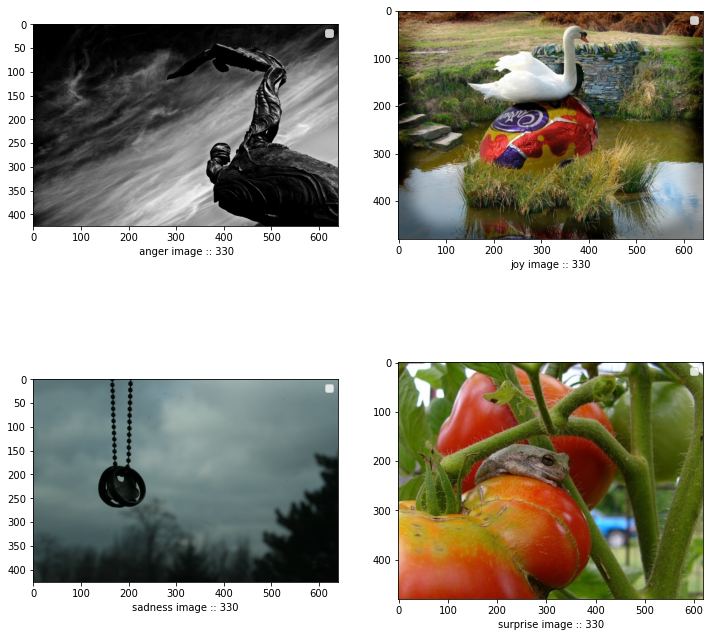

In [6]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.xlabel(f' anger image :: {len(anger_train)}')
plt.imshow(anger_img[0])
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(f'joy image :: {len(joy_train)}')
plt.imshow(joy_img[0])
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(f'sadness image :: {len(sadness_train)}')
plt.imshow(sadness_img[1])
plt.legend()

plt.subplot(2,2,4)
plt.xlabel(f'surprise image :: {len(surprise_train)}')
plt.imshow(surprise_img[0])
plt.legend()

In [7]:
print(anger_img[0].shape)
print(joy_img[0].shape)
print(sadness_img[0].shape)
print(surprise_img[0].shape)

(424, 640, 3)
(480, 640, 3)
(480, 497, 3)
(480, 618, 3)


# 3. Image Augmentation

In [9]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2, #사진 찌그러 뜨리기
    width_shift_range=2,
    height_shift_range=2,
    horizontal_flip=True,
    vertical_flip=False,  #사진이 위아래로 뒤집힐 일은 없을 듯
    fill_mode='nearest',#어차피 화물은 중앙 근처에 있으니 nearest로 함
    brightness_range=[0.3,1.0],
    validation_split = 0.1,
    rescale=1/255.
)

valid_gen = ImageDataGenerator(
    validation_split = 0.1,
    rescale=1/255.
)

### 3-1 Augment 확인

In [ ]:
#np.tile(A,reps) Af를 reps만큼 반복
#imageDataGenerator.flow(이미지,이미지라벨,batch_size)

In [10]:
joy_img[0].shape

(480, 640, 3)

In [11]:
augment_size = 30
joy_augment = train_gen.flow(np.tile(joy_img[0].reshape(480*640*3), augment_size).reshape(-1,480,640,3),
                              np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

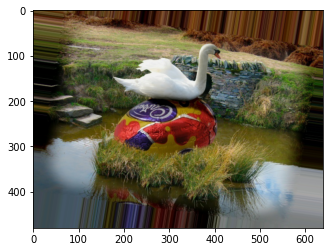

In [12]:
plt.imshow(joy_augment[2])

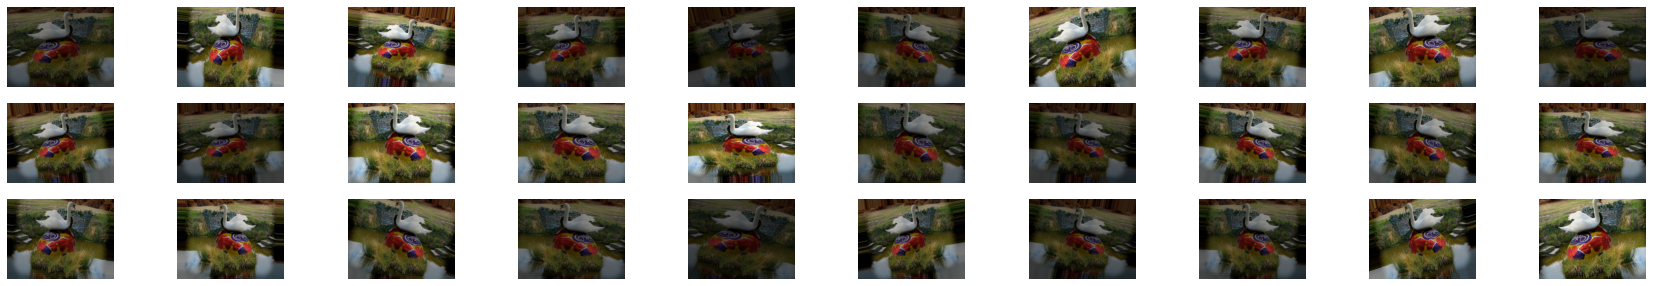

In [13]:
plt.figure(figsize=(30,5))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.axis('off')
    plt.imshow(joy_augment[i-1], cmap='gray')

### 3-2 Load augment data 만들고 dir에 저장

In [14]:
#augment_size2 = 3000

#random_mask2 = np.random.randint(Load_img.shape[0], size=augment_size2)
#Load_augment = Load_img[random_mask2].copy()

In [15]:
#Load_augment.shape

In [16]:
#Load_augmented = train_gen.flow(Load_augment.reshape(-1,492,654,3),
#                             np.zeros(augment_size2), batch_size=augment_size2, shuffle=False).next()[0]

In [17]:
#for i in range(3000):
#    im = Image.fromarray((Load_augmented[i]*255).astype(np.uint8))
#    im.save("F://Competition_No1/datasets/new_train/new_1/{0}.png".format(i))

# 4. generator 생성

In [18]:
train_generator = train_gen.flow_from_directory(directory=root, #이미지가 분류되어있는 디렉토리
                                               target_size=(224,224), #이미지들을 244x244로 resizing
                                               classes=['surprise','sadness','joy','anger'],
                                               class_mode='categorical', #output 클래스 형태
                                               batch_size=32, #미니배치 사이즈
                                               shuffle=True,
                                               subset='training')

valid_generator = valid_gen.flow_from_directory(directory=root,
                                               target_size=(224,224),
                                               classes=['surprise','sadness','joy','anger'],
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               subset='validation')

Found 891 images belonging to 4 classes.
Found 99 images belonging to 4 classes.


In [19]:
#label의 클래스 확인
print(train_generator.class_indices)
print(valid_generator.class_indices)

#step수 (1epoch 당 몇번 weight를 업데이트를 할 것인지)
len(train_generator), len(valid_generator)

{'surprise': 0, 'sadness': 1, 'joy': 2, '\x08anger': 3}
{'surprise': 0, 'sadness': 1, 'joy': 2, '\x08anger': 3}


(28, 4)

# 5. 모델 생성 (ResNet50)

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [21]:
pretrained_model = ResNet50(input_shape=(224,224,3),include_top=False, weights=None)
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [22]:
def create_model(verbose=False):
    input_tensor = Input(shape=(224,224,3))
    pretrained_model = ResNet50(input_tensor=input_tensor, include_top=False, weights='imagenet')
    pretrained_model.trainanble = False
    pretrained_output = pretrained_model.output
    
    #Customize Classifier layer
    x = GlobalAveragePooling2D()(pretrained_output)
    x = Dense(128,activation='relu')(x)
    output = Dense(units=4, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
    return model

model = create_model(verbose=False)

#모델 컴파일
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization) 

# 6. 모델 1차 학습

In [23]:
#모델 학습

history = model.fit_generator(
    train_generator, 
    validation_data = valid_generator,
    epochs=40,
    callbacks=[ ModelCheckpoint('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5',monitor='val_accuracy',save_best_only=True,verbose=1),
              EarlyStopping(patience=15)] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/40
28/28 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.6139
Epoch 1: val_accuracy improved from -inf to 0.32323, saving model to /content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5
28/28 [==============================] - 33s 857ms/step - loss: 0.9009 - accuracy: 0.6139 - val_loss: 1.1915 - val_accuracy: 0.3232
Epoch 2/40
28/28 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8339
Epoch 2: val_accuracy improved from 0.32323 to 0.38384, saving model to /content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5
28/28 [==============================] - 23s 835ms/step - loss: 0.4487 - accuracy: 0.8339 - val_loss: 1.1681 - val_accuracy: 0.3838
Epoch 3/40
28/28 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.9450
Epoch 3: val_accuracy did not improve from 0.38384
28/28 [==============================] - 20s 715ms/step - loss: 0.1983 - accuracy: 0.9450 - val_loss: 1.4155 - val_accuracy: 0.3030
Epoch 4/40
28/

### 6-1 1차 평가

In [24]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "<멋쟁이사자처럼> 쏘카", "images")
test = glob.glob(os.path.join(root, 'test/*.JPG'))

In [25]:
#모델 평가
test0 = np.array(list(map(lambda x: (img_to_array(load_img(test[x]).resize((224, 224)), dtype=np.uint8)), range(len(test)))))/255.

In [26]:
model = load_model('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5')
start = time.time()
pred1 = model.predict(test0)
end = time.time()
seconds = end-start
print("Time taken : {0}".format(seconds))
#pred1 = np.argmax(pred1,axis=1)
pred1

Time taken : 1.3651492595672607


array([[9.9569523e-01, 2.3923430e-03, 1.7676473e-03, 1.4474546e-04],
       [6.0539246e-01, 1.1437198e-01, 2.8004688e-01, 1.8864078e-04],
       [2.3927209e-03, 9.8967195e-01, 7.7470057e-03, 1.8835127e-04],
       [5.2412607e-02, 1.6855279e-01, 7.7871245e-01, 3.2218712e-04],
       [5.2412607e-02, 1.6855279e-01, 7.7871245e-01, 3.2218712e-04],
       [2.4794266e-01, 7.2748321e-01, 2.3985079e-02, 5.8913551e-04],
       [1.9657032e-01, 7.8041518e-01, 2.0288289e-02, 2.7261709e-03]],
      dtype=float32)

In [27]:
np.argmax(pred1,axis=1)

array([0, 0, 1, 2, 2, 1, 1])

# 7. Fine-Tuning (모델 재학습)

In [28]:
len(model.layers)

178

In [29]:
for layer in model.layers[:-7]:
    layer.trainable = False
for layer in model.layers[-7:]:
    layer.trainable = True

In [30]:
from tensorflow.keras.optimizers import SGD

model.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [31]:
history = model.fit_generator(
    train_generator, 
    validation_data = valid_generator,
    epochs=20,
    callbacks=[ ModelCheckpoint('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5',monitor='val_accuracy',save_best_only=True,verbose=1),
              EarlyStopping(patience=5)] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7542
Epoch 1: val_accuracy improved from -inf to 0.60606, saving model to /content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5
28/28 [==============================] - 22s 688ms/step - loss: 0.8026 - accuracy: 0.7542 - val_loss: 1.7735 - val_accuracy: 0.6061
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.8013
Epoch 2: val_accuracy did not improve from 0.60606
28/28 [==============================] - 18s 634ms/step - loss: 0.5736 - accuracy: 0.8013 - val_loss: 1.8650 - val_accuracy: 0.5455
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.8171
Epoch 3: val_accuracy did not improve from 0.60606
28/28 [==============================] - 18s 623ms/step - loss: 0.5258 - accuracy: 0.8171 - val_loss: 1.9134 - val_accuracy: 0.5455
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.7935

# 8. 최종모델 load & 성능테스트

In [32]:
# 최종 모델 불러오기
from tensorflow.python.keras.models import load_model
from tensorflow.keras.preprocessing import image
model_final = tf.keras.models.load_model('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/mood_classifier_dw.h5')

In [33]:
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)

{0: 'surprise', 1: 'sadness', 2: 'joy', 3: '\x08anger'}


In [34]:
img = image.load_img('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images/test/IMG_9879.JPG' , target_size = (224 , 224))

In [35]:
img = image.img_to_array(img, dtype=np.uint8)
img = np.array(img)/255.0
img = img.reshape(1,224,224,3)

In [36]:
from PIL import Image

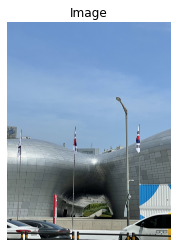

In [37]:
img = Image.open('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images/test/IMG_9879.JPG')

plt.title('Image')
plt.axis('off')
deg_img = img.transpose(Image.ROTATE_270)
 
plt.imshow(deg_img)

In [38]:
def prediction(test_path):
    img = Image.open(test_path)


    plt.title('Image')
    plt.axis('off')
    deg_img = img.transpose(Image.ROTATE_270)
 
    plt.imshow(deg_img)

    img = image.load_img(test_path , target_size = (224 , 224))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0
    img = img.reshape(1,224,224,3)

    predict = model_final.predict(img)
    predicted_class = labels[np.argmax(predict)]

    print('Prediction Value: ' , np.max(predict))
    print("Classified:",predicted_class)

Prediction Value:  0.98786396
Classified: surprise


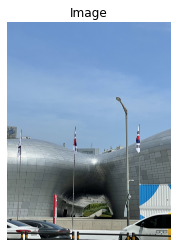

In [39]:
prediction('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images/test/IMG_9879.JPG')

Prediction Value:  0.7315144
Classified: sadness


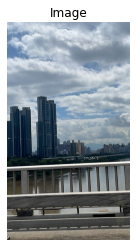

In [40]:
prediction('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images/test/IMG_0332.JPG')

Prediction Value:  0.8936037
Classified: sadness


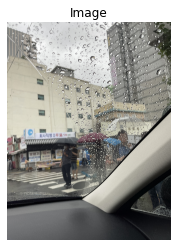

In [41]:
prediction('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images/test/IMG_0280.JPG')

Prediction Value:  0.82730263
Classified: joy


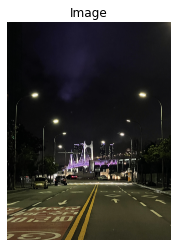

In [42]:
prediction('/content/drive/MyDrive/<멋쟁이사자처럼> 쏘카/images/test/IMG_0247.JPG')